<a href="https://colab.research.google.com/github/imid12/FocusLens/blob/main/accesswebcamwithear.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

📷 Starting Webcam... Click 'Capture & Analyze' in the video window below.


<IPython.core.display.Javascript object>

Saved to photo.jpg


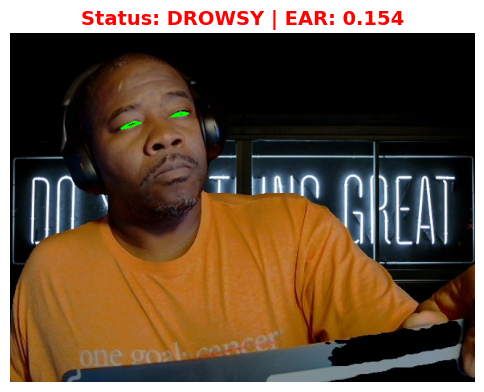

In [9]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import cv2
import dlib
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt

# --- 1. SETUP DLIB & EAR LOGIC (Re-defining for safety) ---
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("/content/shape_predictor_68_face_landmarks.dat")

def eye_aspect_ratio(eye):
    A = dist.euclidean(eye[1], eye[5])
    B = dist.euclidean(eye[2], eye[4])
    C = dist.euclidean(eye[0], eye[3])
    return (A + B) / (2.0 * C)

# --- 2. JAVASCRIPT HELPER (To access local webcam) ---
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture & Analyze';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

# --- 3. EXECUTE CAPTURE ---
try:
  print("📷 Starting Webcam... Click 'Capture & Analyze' in the video window below.")
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # --- 4. RUN ALERTNESS DETECTION ON CAPTURED IMAGE ---
  img = cv2.imread(filename)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  faces = detector(gray)

  if len(faces) == 0:
      print("❌ No face detected in the webcam photo.")
      plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      plt.axis('off')
      plt.show()
  else:
      for face in faces:
          shape = predictor(gray, face)
          coords = np.zeros((68, 2), dtype="int")
          for i in range(0, 68):
              coords[i] = (shape.part(i).x, shape.part(i).y)

          # Calculate EAR
          leftEye = coords[42:48]
          rightEye = coords[36:42]
          avgEAR = (eye_aspect_ratio(leftEye) + eye_aspect_ratio(rightEye)) / 2.0

          # Draw visualizations
          cv2.drawContours(img, [cv2.convexHull(leftEye)], -1, (0, 255, 0), 2)
          cv2.drawContours(img, [cv2.convexHull(rightEye)], -1, (0, 255, 0), 2)

          # Display
          plt.figure(figsize=(6,6))
          plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

          status = "ATTENTIVE" if avgEAR > 0.25 else "DROWSY"
          color = "green" if avgEAR > 0.25 else "red"

          plt.title(f"Status: {status} | EAR: {avgEAR:.3f}", color=color, fontsize=14, fontweight='bold')
          plt.axis('off')
          plt.show()

except Exception as err:
  print(str(err))